# General system and one Buttiker lead added.

In [27]:
import kwant
import math
import cmath
from matplotlib import pyplot as plt
import numpy as np
import tinyarray


from scipy import optimize
import scipy
import time
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

In [2]:
import sys
sys.path.insert(0, 'path_to_modules')

In [29]:
def list_tag_transmission_functions(nleads,systf,emin,emax,de):
    """ Input: 
            - finalized kwant system (systf) with nleads attached
            - energy window: [emin,emax,de] on which the transmission are calculated.  
        Ouput:  
            - 2 Lists of transmissions from lead i to j (Tij) and j to i (Tji)  where i != j:
                * One list for the + magnetization and one for the opposite - magnetization
                * IMPORTANT: Buttiker reciproical relations are used here: Tij(m) = Tji(-m)!
            - tag_list_ij,tag_list_ji are explicit labels for the calculated transmission 
                (to keep track of what transmission is calculted )"""
    

    list_transmissions_P = []
    list_transmissions_M = []

    for lead_i in range(nleads):
        energies, Tij_list_i,tag_list_ij_i  = CalculateCurrentN.Tij(systf,lead_i =lead_i,n_leads=nleads,
                                                  emin=emin,emax=emax, de=de,
                                                  plot_var=False,check_hermiticity=True)

        energies, Tji_list_i,tag_list_ji_i   = CalculateCurrentN.Tji(systf,lead_i =lead_i,n_leads=nleads,
                                                  emin=emin,emax=emax, de=de,
                                                  plot_var=False,check_hermiticity=True)



        list_transmissions_P.append([ Tij_list_i,tag_list_ij_i, Tji_list_i,tag_list_ji_i ])
        
        # Using the Buttiker reciprocity relations
        list_transmissions_M.append([ Tji_list_i,tag_list_ij_i, Tij_list_i,tag_list_ji_i ])
        
    return energies,list_transmissions_P,list_transmissions_M 

In [30]:
def overlap_two_lists(list1,list2):
    "Returns the overlapping elements of list1 and list2"
    joinedlist = sorted(list(set(list1+list2)) )
    overlap_list = []

    for element in joinedlist:

        if element in list1 and element in list2:
            overlap_list.append(element)
            
            
    return overlap_list


def index_list_adjusted(IP_list_2,IM_list_2,V_list,nacc=7,plot_current=True):
    
    """ Input: - Buttiker probe currents for plus/minus magnetization 
              - list of voltages V_list,
              - accuracy for convergence 
       Ouput: - List of voltages for which both Buttiker currents converged, the default accuracy is 10**-7.
              - List of indices corresponding to returned voltage list."""
    
    if plot_current == True:
        plt.plot(V_list,IM_list_2,label = 'IB(-m)')
        plt.plot(V_list,IP_list_2,label = 'IB(+m)')
        plt.legend()
        plt.xlabel('Voltage ')
        plt.ylabel('Charge Current ')




        plt.show()
    
    index_list_p = []
    index_list_m = []
    
    
    # Values in IM_list_2,IP_list_2 that are to large (current IB did not converge ) are ignored
    # corresponding voltage are added to a list
    for i in range(len(IM_list_2)):
        
        IBm = np.round(IM_list_2[i],nacc)
        
        if IBm == 0:
            index_list_m.append(i)

        if IBm != 0:
            print(i,V_list[i],IM_list_2[i])
            
    for i in range(len(IP_list_2)):
        IBp = np.round(IP_list_2[i],nacc) 
        if IBp == 0:
            index_list_p.append(i)

        if IBp != 0:
            print(i,V_list[i],IP_list_2[i])
            
            
    # Find the overlapping set
    overlap_list = overlap_two_lists(index_list_p,index_list_m)
    
    V_list_adjusted = [ V_list[i] for i in overlap_list]
    
    return overlap_list, V_list_adjusted


In [31]:

def calc_MR_list(IP_list_0,IM_list_0,V_list,n=16):
    
    """Input: Currents into left lead for plus/minus magnetization of the lead, for the voltages in V_list.\
       Ouput: MR for the voltages in V_list"""
    #At V = 0 we must have I(m) + I(-m) = 0
    # numerical errors often lead to:  I(m) +I(-m) = 10**-12, 
    # which leads to division of a small number in the MR.
    # therefore it necessary to round I(m) +I(-m) to 'n' digits.


 
    #Calculate MR"
    MR_list = []

    for k in range(len(V_list)):
        V = V_list[k]
        ILm = IM_list_0[k]
        ILp = IP_list_0[k]

        T = ILp + ILm
        
        
        if np.round(T,n) == 0:
            MR_list.append(0)
        if np.round(T,n) != 0:

            P = 100*(ILp - ILm)/T


            MR_list.append(P)
            
    return MR_list

#### Plot functions 

In [32]:
import PlotFunctions

### Test system

In [34]:
import GoldLeadsSystem_1Probe

In [35]:
def make_system(B=1, u0 = -5.3,t0 =50,
                     nlayers = 3, xi_d = 0.6, xi_p = 0.006,
                    Txz = 3,Tyz = 3,d_L= 50,
                    txz_left_1=1,tyz_left_1=0,
                    txz_left_2=1,tyz_left_2=1,
                    txz_left_3=0,tyz_left_3=1,
                    plot_left = False,
                    txz_right_1=1,tyz_right_1=0, 
                    txz_right_2=1,tyz_right_2=1,
                    txz_right_3=0,tyz_right_3=1,
                    plot_right = False,
                    nrings =6 ,tvec=3,E_z=0,r=1.4,zstart=0,b=3.6,
                    chirality_left=True,
                    u=-18+9.9 ,delta_e=-12.6,Es=-6.21,I=2,M=1,E1=0,E2=0
                     ):
    
    system = GoldLeadsSystem_1Probe.make_system_toy_1B(nlayers, xi_d,xi_p,
                Txz,Tyz, d_L,
                 txz_left_1,tyz_left_1,
                txz_left_2,tyz_left_2,
                txz_left_3,tyz_left_3,
                plot_left,
                txz_right_1,tyz_right_1, 
                txz_right_2,tyz_right_2,
                txz_right_3,tyz_right_3,
                plot_right,
                nrings ,tvec,E_z,r,zstart,b,
                chirality_left,
                u,delta_e,Es,
                B,u0,t0,I,M,E1,E2)
    
    
    
    systemf = system.finalized()
    return systemf
    
  

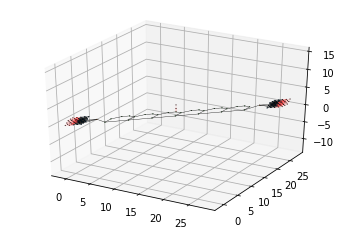

In [36]:

syst_Sgeom = make_system(I=1,M=0,E1=0,E2=1)
kwant.plot(syst_Sgeom,site_size=0.1,hop_lw=0.1);


# Formulas for calculating currents

In [37]:
import CalculateCurrentN

# Define Systems

#### Set system parameters

In [38]:
# chirality_left:
# True = M-helicene
# False = P-helicene

In [39]:
B,t0,u0 = 1,50,-5.3
attpos , attposM  ,attposE1 , attposE2 = 2,1,0,0

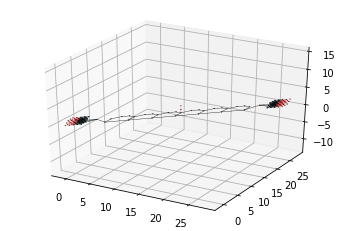

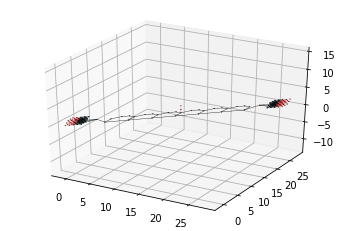

In [40]:
# total number of leads = L,R lead + "# Buttiker Probes"
nleads = 2+1 


#System with positive Magnetization
syst_Sgeom_P = make_system(B= abs(B),t0=t0,u0=u0,I=attpos ,
                           M =attposM  ,E1=attposE1 , E2=attposE2)
kwant.plot(syst_Sgeom_P,site_size=0.1,hop_lw=0.1);

#System with negative Magnetization
syst_Sgeom_M = make_system(B= -abs(B),t0=t0,u0=u0,I=attpos,
                           M =attposM  ,E1=attposE1 , E2=attposE2)
kwant.plot(syst_Sgeom_M,site_size=0.1,hop_lw=0.1);

# Set lower,lower bound

In [41]:
# fix voltage and fermi energy
ef     = -5.3
Vmax   = 1.12
V_list = np.linspace(0,Vmax,10) 



# energies in the bias window
de =0.012
emin, emax = ef - Vmax/2 , ef + Vmax/2
print(emin,emax,de)

-5.859999999999999 -4.74 0.012


# Calculate transmissions

# $T_{ij}(m), T_{ji}(m)$

In [42]:
energies,list_tags_transmissions_P,list_tags_transmissions_M =  list_tag_transmission_functions(nleads=nleads,
                                                                                                systf=syst_Sgeom_P,
                                                                                      emin=emin,emax=emax,de=de)

# Plot Transmissions

# $T_{ij}(m), T_{ji}(m)$

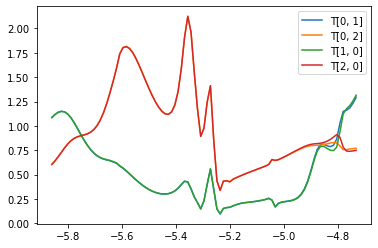

In [43]:
CalculateCurrentN.plot_transmission_i(0,list_tags_transmissions_P,energies)

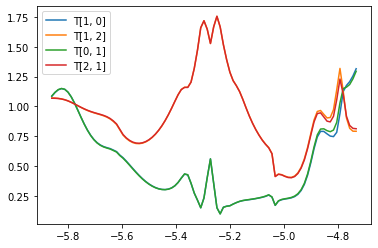

In [44]:
CalculateCurrentN.plot_transmission_i(1,list_tags_transmissions_P,energies)

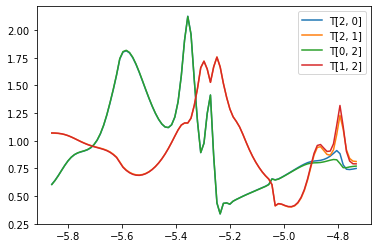

In [45]:
CalculateCurrentN.plot_transmission_i(2,list_tags_transmissions_P,energies)

## Root Finding: positive magnetization

### $\mu_B(m)$

In [46]:
# muB(m) is a voltage dependent quantity.
# muB(m) is the chemical potential of Buttiker probe for positive volatges.

In [47]:
#intial guess for muB's 
# make i

muBs_P_sol_list = []

for V in V_list:
    
    if V == 0:
        muBs0_P_list = [ef for i in range(nleads-2)]
    if V != 0:
        muBs0_P_list = [u0 for i in range(nleads-2)]


    print('--- V = {} --- '.format(V))
    sol = optimize.root(CalculateCurrentN.currents_B_probe, muBs0_P_list, method='hybr',args = (ef,V,nleads,
                                                                            list_tags_transmissions_P,energies,
                                                                              syst_Sgeom_P,True) ,tol = 10**-17)
    
    x_list_sol = sol.x
    muBs_P_sol_list.append(x_list_sol)
    
    print('--- mu2,mu3,... ={}'.format(x_list_sol))


--- V = 0.0 --- 
[-2.886579864025407e-14]
[-2.886579864025407e-14]
[-2.886579864025407e-14]
[2.0905283815153552e-07]
[-0.0105736766213127]
--- mu2,mu3,... =[-5.3]
--- V = 0.12444444444444445 --- 
[0.027235921475581737]
[0.027235921475581737]
[0.027235921475581737]
[0.027236130528448754]
[0.0002982435609180101]
[-2.0391249346385365e-05]
[2.6829222377067197e-07]
[3.2579450248704234e-10]
[-5.329070518200751e-15]
[-1.1102230246251565e-15]
--- mu2,mu3,... =[-5.31039593]
--- V = 0.2488888888888889 --- 
[0.06726971214002697]
[0.06726971214002697]
[0.06726971214002697]
[0.06726992119289399]
[0.0006550892243197826]
[-3.053206502157124e-05]
[2.0641290232603637e-08]
[6.530331830845171e-13]
[4.440892098500626e-16]
[4.440892098500626e-16]
[6.530331830845171e-13]
[2.178545124298381e-07]
[4.440892098500626e-16]
--- mu2,mu3,... =[-5.325652]
--- V = 0.37333333333333335 --- 
[0.08754895863181344]
[0.08754895863181344]
[0.08754895863181344]
[0.08754916768468046]
[-0.000610751748974625]
[5.234181884428146

# $I_{L,R,B}(+m)$

In [48]:
IP_list_0 = []
IP_list_1 = []
IP_list_2 = []


for n in range(len(V_list)):
    
    # Generate muLs
    muB_list = muBs_P_sol_list[n]
    V        = V_list[n]
    
    #Current into lead 0
    I0 = CalculateCurrentN.currents_leadi_probe(0,muB_list,ef,V,nleads,
                         energies,list_tags_transmissions_P,syst_Sgeom_P,
                         print_bool=False)
    
    IP_list_0.append(I0)
    
    #Current into lead 1
    I1 = CalculateCurrentN.currents_leadi_probe(1,muB_list,ef,V,nleads,
                         energies,list_tags_transmissions_P,syst_Sgeom_P,
                         print_bool=False)
    
    IP_list_1.append(I1)
    
    #Current into lead 2,3,..
    IB_list = CalculateCurrentN.currents_B_probe( muB_list, ef,V,nleads,list_tags_transmissions_P,energies,
                                                                              syst_Sgeom_P,False)
    
    IP_list_2.append(IB_list)

    print('V= {}'.format(V))

V= 0.0
V= 0.12444444444444445
V= 0.2488888888888889
V= 0.37333333333333335
V= 0.4977777777777778
V= 0.6222222222222222
V= 0.7466666666666667
V= 0.8711111111111112
V= 0.9955555555555556
V= 1.12


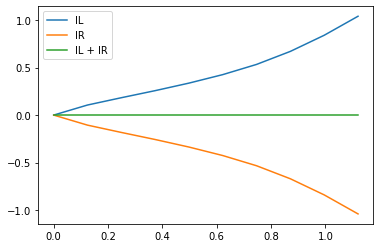

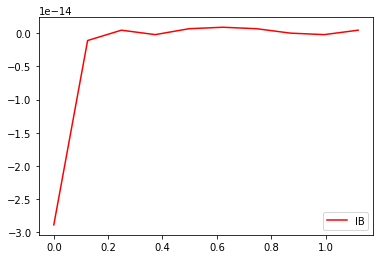

In [49]:
plt.plot(V_list,IP_list_0,label = 'IL')
plt.plot(V_list,IP_list_1,label = 'IR')
plt.plot(V_list,np.add(IP_list_1,IP_list_0),label = 'IL + IR')
plt.legend()

plt.show()

plt.plot(V_list,IP_list_2,label = 'IB',color = 'red')
plt.legend()


plt.show()

## Save Values

In [50]:
# file = open("IP_list_0{}nleads_{}B_de{}_t0{}_u0{}_Pos_IH{}_ME1E2{}{}{}.txt".format(nleads,abs(B),de,t0,u0,attpos,attposM,attposE1,attposE2 ),'w')
# np.savetxt(file,IP_list_0 )
# file.close()

# file = open("IP_list_1{}nleads_{}B_de{}_t0{}_u0{}_Pos_IH{}_ME1E2{}{}{}.txt".format(nleads,abs(B),de,t0,u0,attpos,attposM,attposE1,attposE2 ),'w')
# np.savetxt(file,IP_list_1 )
# file.close()

# file = open("IP_list_2{}nleads_{}B_de{}_t0{}_u0{}_Pos_IH{}_ME1E2{}{}{}.txt".format(nleads,abs(B),de,t0,u0,attpos,attposM,attposE1,attposE2 ),'w')
# np.savetxt(file,IP_list_2 )
# file.close()

# $\bar{\mu}_B(m)$

In [51]:
# muBbar(m) is the chemical potential of Buttiker probe for negative volatges.

# NOTE:
# The chemical potential of the left,right lead are swapped and muBbar is calculated for positive voltages
# This is equivalent to calculating the chemical potential for negative voltages.

In [52]:
# intial guess for muB's 
# make i

mubarBs_P_sol_list = []

for n in range(len(V_list)):
    
    V = V_list[n]
    if V == 0:
        muBs0_P_list = [muBs_P_sol_list[n]]
    if V != 0:
        muBs0_P_list = [muBs_P_sol_list[n]]
    
#     if V == 0:
#         muBs0_P_list = [ef]
#     if V != 0:
#         muBs0_P_list = [ef]


    print('--- V = {} --- '.format(V))
    solbar = optimize.root(CalculateCurrentN.currents_B_probe, muBs0_P_list, method='hybr',args = (ef,-V,nleads,
                                                                            list_tags_transmissions_P,energies,
                                                                              syst_Sgeom_P,True) )
    
    x_list_solbar = solbar.x
    mubarBs_P_sol_list.append(x_list_solbar)
    
    print('--- mu2,mu3,... ={}'.format(x_list_solbar))



--- V = 0.0 --- 
[-2.886579864025407e-14]
[-2.886579864025407e-14]
[-2.886579864025407e-14]
[2.0905283815153552e-07]
[-0.0105736766213127]
--- mu2,mu3,... =[-5.3]
--- V = 0.12444444444444445 --- 
[-0.03631505802769808]
[-0.03631505802769808]
[-0.03631505802769808]
[-0.036314834053667866]
[-0.002593638391615638]
[6.134780323452382e-05]
[-1.789617285474776e-07]
[-1.247757452915721e-11]
[8.881784197001252e-16]
--- mu2,mu3,... =[-5.29660156]
--- V = 0.2488888888888889 --- 
[-0.07252413765192811]
[-0.07252413765192811]
[-0.07252413765192811]
[-0.07252391979741613]
[-0.0032215749623167866]
[5.3033149568948446e-05]
[-1.808743785858269e-07]
[-1.0312195541928304e-11]
[1.7763568394002505e-15]
--- mu2,mu3,... =[-5.29802519]
--- V = 0.37333333333333335 --- 
[-0.08241271097759739]
[-0.08241271097759739]
[-0.08241271097759739]
[-0.08241248117979971]
[-0.006292638386116822]
[-0.00015230004101574046]
[8.39183786460751e-07]
[-1.1529155408140923e-10]
[2.4424906541753444e-15]
--- mu2,mu3,... =[-5.3019502

# $\bar{I}_{L,R,B}(+m)$

In [53]:
# The current for negative voltages.

In [54]:
IbarP_list_0 = []
IbarP_list_1 = []
IbarP_list_2 = []


for n in range(len(V_list)):
    
    # Generate muLs
    muB_list = mubarBs_P_sol_list[n]
    V        = V_list[n]
    
    #Current into lead 0
    I0 = CalculateCurrentN.currents_leadi_probe(0,muB_list,ef,-V,nleads,
                         energies,list_tags_transmissions_P,syst_Sgeom_P,
                         print_bool=False)
    
    IbarP_list_0.append(I0)
    
    #Current into lead 1
    I1 = CalculateCurrentN.currents_leadi_probe(1,muB_list,ef,-V,nleads,
                         energies,list_tags_transmissions_P,syst_Sgeom_P,
                         print_bool=False)
    
    IbarP_list_1.append(I1)
    

    #Current into lead 2,3,..
    IB_list = CalculateCurrentN.currents_B_probe( muB_list, ef,-V,nleads,list_tags_transmissions_P,energies,
                                                                              syst_Sgeom_P,False)
    
    IbarP_list_2.append(IB_list)

    print('V= {}'.format(V))

V= 0.0
V= 0.12444444444444445
V= 0.2488888888888889
V= 0.37333333333333335
V= 0.4977777777777778
V= 0.6222222222222222
V= 0.7466666666666667
V= 0.8711111111111112
V= 0.9955555555555556
V= 1.12


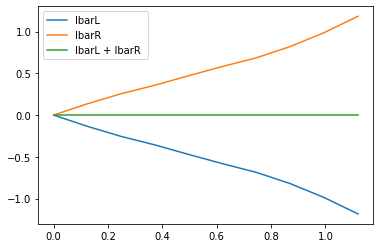

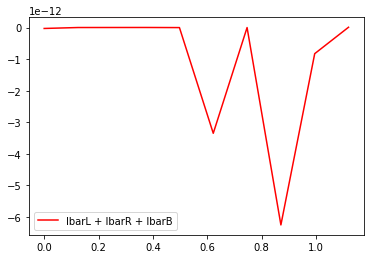

In [55]:
plt.plot(V_list,IbarP_list_0,label = 'IbarL')
plt.plot(V_list,IbarP_list_1,label = 'IbarR')
plt.plot(V_list,np.add(IbarP_list_1,IbarP_list_0),label = 'IbarL + IbarR ')


plt.legend()

plt.show()



plt.plot(V_list,IbarP_list_2,label = 'IbarL + IbarR + IbarB',color = 'red')
plt.legend()


plt.show()

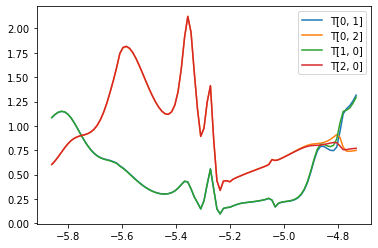

In [56]:
CalculateCurrentN.plot_transmission_i(0,list_tags_transmissions_M,energies)

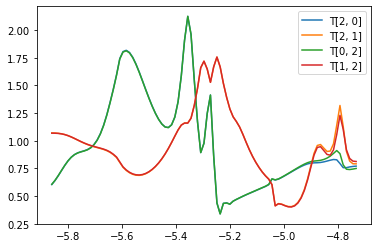

In [57]:
CalculateCurrentN.plot_transmission_i(2,list_tags_transmissions_M,energies)

# Negative Magnetization

## ${\mu}_B(-m)$

In [58]:
# muB(-m) is a voltage dependent quantity.
# muB(-m) is the chemical potential of Buttiker probe for positive volatges.

In [59]:

# list for solutions
muBs_M_sol_list = []

for V in V_list:
    
    #intial guess for muB's 
    if V == 0:
        muBs0_M_list = [ef for i in range(nleads-2)]
    if V != 0:
        muBs0_M_list = [ u0 for i in range(nleads-2)]
        
        
    print('--- V = {} --- '.format(V))
    sol = optimize.root(CalculateCurrentN.currents_B_probe, muBs0_M_list, method='hybr',args = (ef,V,nleads,
                                                                            list_tags_transmissions_M,energies,
                                                                              syst_Sgeom_M,True) ,tol = 10**-17)
    
    x_list_sol = sol.x
    muBs_M_sol_list.append(x_list_sol)
    
    print('--- mu2,mu3,... ={}'.format(x_list_sol))


--- V = 0.0 --- 
[2.930988785010413e-14]
[2.930988785010413e-14]
[2.930988785010413e-14]
[2.0905289699335583e-07]
[-0.01057367662128117]
--- mu2,mu3,... =[-5.3]
--- V = 0.12444444444444445 --- 
[0.027212160398256025]
[0.027212160398256025]
[0.027212160398256025]
[0.027212369451123708]
[0.0002993158683326502]
[-1.9896132298580227e-05]
[2.428361207673646e-07]
[2.628166573259705e-10]
[-4.440892098500626e-15]
[1.1102230246251565e-15]
--- mu2,mu3,... =[-5.31038752]
--- V = 0.2488888888888889 --- 
[0.06725736661697712]
[0.06725736661697712]
[0.06725736661697712]
[0.0672575756698448]
[0.0006555298449599789]
[-3.054064062313344e-05]
[2.065521798044756e-08]
[6.532552276894421e-13]
[-2.220446049250313e-16]
[-2.220446049250313e-16]
[-6.541434061091422e-13]
[2.1784875370300938e-07]
[-2.220446049250313e-16]
--- mu2,mu3,... =[-5.3256475]
--- V = 0.37333333333333335 --- 
[0.08754863237198429]
[0.08754863237198429]
[0.08754863237198429]
[0.08754884142485198]
[-0.000610720696214262]
[5.2338769259696605

## $\bar{\mu}_B(-m)$

In [60]:
# list for solutions
mubarBs_M_sol_list = []

for n in range(len(V_list)):
    
    V = V_list[n]
    
#       intial guess for muB's 
    if V == 0:
        muBs0_M_list = [muBs_M_sol_list[n]]
    if V != 0:
        muBs0_M_list = [muBs_M_sol_list[n]]
    
    #intial guess for muB's 
#     if V == 0:
#         muBs0_M_list = [ef]
#     if V != 0:
#         muBs0_M_list = [ef]
        
        
    print('--- V = {} --- '.format(V))
    sol = optimize.root(CalculateCurrentN.currents_B_probe, muBs0_M_list, method='hybr',args = (ef,-V,nleads,
                                                                            list_tags_transmissions_M,energies,
                                                                              syst_Sgeom_M,True) )
    
    x_list_sol = sol.x
    mubarBs_M_sol_list.append(x_list_sol)
    
    print('--- mu2,mu3,... ={}'.format(x_list_sol))

--- V = 0.0 --- 
[2.930988785010413e-14]
[2.930988785010413e-14]
[2.930988785010413e-14]
[2.0905289699335583e-07]
[-0.01057367662128117]
--- mu2,mu3,... =[-5.3]
--- V = 0.12444444444444445 --- 
[-0.036267535872932744]
[-0.036267535872932744]
[-0.036267535872932744]
[-0.03626731248934534]
[-0.00250156354952491]
[5.9311323600930166e-05]
[-1.6688295456646074e-07]
[-1.1250111953131636e-11]
[3.1086244689504383e-15]
--- mu2,mu3,... =[-5.29661037]
--- V = 0.2488888888888889 --- 
[-0.0724994466057034]
[-0.0724994466057034]
[-0.0724994466057034]
[-0.07249922875694947]
[-0.0032193841256824562]
[5.295168548835605e-05]
[-1.804400668881101e-07]
[-1.0250467141759145e-11]
[-8.881784197001252e-15]
--- mu2,mu3,... =[-5.2980298]
--- V = 0.37333333333333335 --- 
[-0.08241205845781363]
[-0.08241205845781363]
[-0.08241205845781363]
[-0.08241182866021979]
[-0.006292540677483638]
[-0.00015229914940229072]
[8.391619101821846e-07]
[-1.1528933363535998e-10]
[-3.1086244689504383e-15]
--- mu2,mu3,... =[-5.3019504

# $I_{L,R,B}(-m)$

In [ ]:
IM_list_0 = []
IM_list_1 = []
IM_list_2 = []


for n in range(len(V_list)):
    
    # Generate muLs
    muB_list = muBs_M_sol_list[n]
    V        = V_list[n]
    
    #Current into lead 0
    I0 = CalculateCurrentN.currents_leadi_probe(0,muB_list,ef,V,nleads,
                         energies,list_tags_transmissions_M,syst_Sgeom_M,
                         print_bool=False)
    
    IM_list_0.append(I0)
    
    #Current into lead 1
    I1 = CalculateCurrentN.currents_leadi_probe(1,muB_list,ef,V,nleads,
                         energies,list_tags_transmissions_M,syst_Sgeom_M,
                         print_bool=False)
    
    IM_list_1.append(I1)
    


    #Current into lead 2,3,..,nleads-2
    IB_list = CalculateCurrentN.currents_B_probe( muB_list, ef,V,nleads,list_tags_transmissions_M,energies,
                                                                              syst_Sgeom_M,False)
    
    IM_list_2.append(IB_list)

    print('V= {}'.format(V))

V= 0.0
V= 0.12444444444444445
V= 0.2488888888888889
V= 0.37333333333333335
V= 0.4977777777777778
V= 0.6222222222222222
V= 0.7466666666666667


In [ ]:
plt.plot(V_list,IM_list_0)
plt.plot(V_list,IM_list_1)

plt.plot(V_list,IM_list_2)
plt.show()



# $\bar{I}_{L,R,B}(-m)$

In [ ]:
IbarM_list_0 = []
IbarM_list_1 = []
IbarM_list_2 = []


for n in range(len(V_list)):
    
    # Generate muLs
    muB_list = mubarBs_M_sol_list[n]
    V        = V_list[n]
    
    #Current into lead 0
    I0 = CalculateCurrentN.currents_leadi_probe(0,muB_list,ef,-V,nleads,
                         energies,list_tags_transmissions_M,syst_Sgeom_M,
                         print_bool=False)
    
    IbarM_list_0.append(I0)
    
    #Current into lead 0
    I1 = CalculateCurrentN.currents_leadi_probe(1,muB_list,ef,-V,nleads,
                         energies,list_tags_transmissions_M,syst_Sgeom_M,
                         print_bool=False)
    
    IbarM_list_1.append(I1)
    

    #Current into lead 2,3,..
    IB_list = CalculateCurrentN.currents_B_probe( muB_list, ef,-V,nleads,list_tags_transmissions_M,energies,
                                                                              syst_Sgeom_M,False)
    
    IbarM_list_2.append(IB_list)

    print('V= {}'.format(V))

# D(m),R(m)

In [ ]:
RP_list = np.add(IP_list_0,IbarP_list_0)

DP_list = np.subtract(IP_list_0,IbarP_list_0)

In [ ]:
plt.plot(V_list,RP_list,label =' R(m)')
plt.legend()

plt.xlabel('Voltage ')
plt.ylabel('Current[a.u]')


plt.show()


plt.plot(V_list,DP_list,label ='D(m)')
plt.legend()
plt.xlabel('Voltage ')
plt.ylabel('Current[a.u]')



plt.show()



# R(-m),D(-m)

In [ ]:
RM_list = np.add(IM_list_0,IbarM_list_0)

DM_list = np.subtract(IM_list_0,IbarM_list_0)

In [ ]:
plt.plot(V_list,RM_list,label ='R(-m)')
plt.legend()
plt.xlabel('Voltage ')
plt.ylabel('Current[a.u]')



plt.show()


plt.plot(V_list,DM_list,label ='D(-m)')
plt.legend()
plt.xlabel('Voltage ')
plt.ylabel('Current[a.u]')

plt.show()



# MR

In [ ]:
overlap_list, V_list_adjusted =   index_list_adjusted(IP_list_2,IM_list_2,V_list,nacc=7,plot_current=True  )

In [ ]:
plt.plot(V_list,IM_list_0,label = 'I(-m)')
plt.plot(V_list,IP_list_0,label = 'I(m)')
plt.legend()
plt.xlabel('Voltage ')
plt.ylabel('Current[a.u]')

plt.show()

In [ ]:
dIList = np.subtract(IP_list_0,IM_list_0)

In [ ]:


plt.plot(V_list,dIList,label='DeltaI(m): total',color='orange')

plt.plot(V_list,np.multiply(0.5,np.subtract(DP_list,DM_list)),label='DeltaI(m): odd',color='red')

plt.plot(V_list,np.multiply(0.5,np.subtract(RP_list,RM_list)),label='DeltaI(m): even', color = 'green')


# plt.plot(V_list,RP_list,label='R(m)')
# plt.plot(V_list,RM_list,label='R(-m)')





# Plot labels
plt.xlabel('Voltage ')
plt.ylabel('Charged Current ')
plt.legend()


plt.show()



In [ ]:
MR_list = calc_MR_list(IP_list_0,IM_list_0,V_list,n=12)

In [ ]:
fig = plt.figure(figsize = (15,4.5))

axes1 = fig.add_subplot(1,2,1)
axes2 = fig.add_subplot(1,2,2)


axes1.set_title('|B| = {} , t0 = {}, u0={}, [I = {}, M = {} ,E1 = {} , E2 = {}]'.format(abs(B),t0,u0,
                           attpos,attposM   ,attposE1 , attposE2 ))
axes2.set_title('|B| = {} , t0 = {}, u0={}, [I = {}, M = {} ,E1 = {} , E2 = {}]'.format(abs(B),t0,u0,
                           attpos,attposM   ,attposE1 , attposE2 ) )


axes1.plot(V_list,IM_list_0,color='blue',label = 'I(-m)')
axes1.plot(V_list,IP_list_0,color='orange',label = 'I(m)')
axes1.legend()




axes2.plot(V_list,MR_list,label ='MR',color='red')
axes2.legend()


# axes2.plot(np.min(data,axis=0),'-o',color='red')


all_axes = fig.get_axes()
    
for ax in all_axes:
    ax.set_xlabel("Voltage")


axes1.set_ylabel('[Charge Current]')
axes2.set_ylabel('MR [%]')


fig.tight_layout()




plt.show()